In [43]:
import numpy as np
import pandas as pd
import os
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from isotopde_data_v5 import isotopes


In [44]:
#Covert text files into csv
#convert Absorption Cross Section Data
df_abs = pd.read_csv('Absorption_Cross_Section_Data.txt', delim_whitespace=True)
df_abs.to_csv('Absorption_Cross_Section_Data.csv', index=False)

#convert Capture Cross Section Data
df_capture = pd.read_csv('Capture_Cross_Section_Data.txt', delim_whitespace=True)
df_capture.to_csv('Capture_Cross_Section_Data.csv', index=False)

#convert n2n Cross Section Data
df_n2n = pd.read_csv('n2n_Cross_Section_Data.txt', delim_whitespace=True)
df_n2n.to_csv('n2n_Cross_Section_Data.csv', index=False)

#convert Neutron Energy Groups Data
# Read the file with multi-word headers using proper header rows and column names
df_neutron_energy = pd.read_csv(
    'Neutron_Energy_Groups.txt',
    delim_whitespace=True,
    header=None,
    skiprows=1,
    names=[
        'Energy Group',
        'Lower Boundary (eV)',
        'Upper Boundary (eV)'
    ]
)
df_neutron_energy.to_csv('Neutron_Energy_Groups.csv', index=False)


In [45]:
#Create a function to load cross-section data from CSV files
# Here's a corrected version of the function:
def load_cross_section_data(file_path):
    df = pd.read_csv(file_path)
    # Do not set the index, just return the dataframe as a dict
    return df.to_dict(orient='list')

# Load cross-section data
absorption_data = load_cross_section_data('Absorption_Cross_Section_Data.csv')
capture_data = load_cross_section_data('Capture_Cross_Section_Data.csv')
n2n_data = load_cross_section_data('n2n_Cross_Section_Data.csv')

#Build a dictionary for each reaction type
absorption_data = {isotope: data for isotope, data in absorption_data.items() if isotope in isotopes}
capture_data = {isotope: data for isotope, data in capture_data.items() if isotope in isotopes}
n2n_data = {isotope: data for isotope, data in n2n_data.items() if isotope in isotopes}
# Create a dictionary to hold all cross-section data
cross_section_data = {
    'absorption': absorption_data,
    'capture': capture_data,
    'n2n': n2n_data
}
#print("absorption_data:", absorption_data)
#print("capture_data:", capture_data)
print("n2n_data:", n2n_data)

n2n_data: {'U237': [0.32655, 0.3834, 0.413, 0.46847, 0.5794, 0.65141, 0.71767, 0.78894, 0.84478, 0.9408, 1.1441, 1.2536, 1.4025, 1.5261, 1.585, 1.6091, 1.6161, 1.6103, 1.5953, 1.5716, 1.5354, 1.4833, 1.4144, 1.3221, 1.2432, 1.1667, 0.95301, 0.66218, 0.31005, 0.090021, 0.0042974, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],

In [54]:
# Integrate cross-section data into the isotopes dictionary
for iso in isotopes:
    #print(f"Processing isotope: {iso}")
    # Add capture (n, gamma) if available
    if iso in cross_section_data['capture']:
        #print(f"Adding capture data for {iso}")
        # Convert barns to cm^2
        isotopes[iso]['n_gamma'] = [x * 1.0e-24 for x in cross_section_data['capture'][iso]]
    # Add n,2n if available
    if iso in cross_section_data['n2n']:
        #print(f"Adding n2n data for {iso}")
        isotopes[iso]['n_2n'] = [x * 1.0e-24 for x in cross_section_data['n2n'][iso]]
    # Add absorption (n_fission) if available
    if iso in cross_section_data['absorption']:
        #print(f"Adding absorption data for {iso}")
        isotopes[iso]['n_fission'] = [x * 1.0e-24 for x in cross_section_data['absorption'][iso]]

#print("isotopes:", isotopes)


Text(0, 0.5, 'Flux')

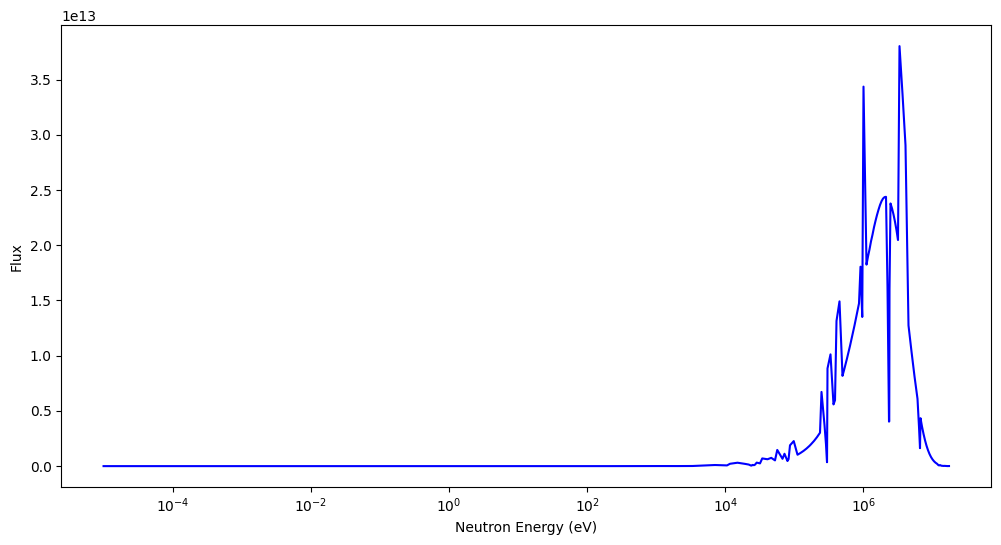

In [47]:
# Load the 175-group flux data
flux = pd.read_csv('Flux.txt', header=None).squeeze().values
#load neutron energy groups
neutron_energy_groups = pd.read_csv('Neutron_Energy_Groups.csv')

#plot neutron energy groups with respect ot flux
plt.figure(figsize=(12, 6))
plt.plot(neutron_energy_groups['Lower Boundary (eV)'], flux, label='Flux', color='blue')
plt.xscale('log')
plt.xlabel('Neutron Energy (eV)')
plt.ylabel('Flux')

In [48]:
#Load Flux (175 - Group vector)
flux_sum = np.sum(flux)

#Load Materials file
materials_df = pd.read_csv('Materials.txt', delim_whitespace=True, header=None, names=['Isotope', 'Concentration'])

####Below is a test code to compute reaction rates based on the flux and isotopes data
#Compute group wise reaction rates
def compute_groupwise_reaction_rates(isotopes, isotope_concentrations, flux, flux_sum):
    """
    Compute group-wise reaction rates for all isotopes in the model.

    Parameters:
        isotopes (dict): Isotope data dictionary.
        isotope_concentrations (dict): {isotope: concentration} for all isotopes (including produced ones).
        flux (np.ndarray): Neutron flux vector.
        flux_sum (float): Sum of flux vector.

    Returns:
        dict: Dictionary with keys 'capture', 'absorption', 'n2n', each mapping to {isotope: rates array}.
    """
    rates = {'capture': {}, 'absorption': {}, 'n2n': {}}
    for isotope in isotope_concentrations:
        if isotope in isotopes:
            # (n, gamma)
            n_gamma = isotopes[isotope].get('n_gamma', 0.0)
            if isinstance(n_gamma, (list, np.ndarray)):
                rates['capture'][isotope] = flux * np.array(n_gamma) / flux_sum
            else:
                rates['capture'][isotope] = np.zeros_like(flux)
            # (n, fission)
            n_fission = isotopes[isotope].get('n_fission', 0.0)
            if isinstance(n_fission, (list, np.ndarray)):
                rates['absorption'][isotope] = flux * np.array(n_fission) / flux_sum
            else:
                rates['absorption'][isotope] = np.zeros_like(flux)
            # (n,2n)
            n_2n = isotopes[isotope].get('n_2n', 0.0)
            if isinstance(n_2n, (list, np.ndarray)):
                rates['n2n'][isotope] = flux * np.array(n_2n) / flux_sum
            else:
                rates['n2n'][isotope] = np.zeros_like(flux)
        else:
            print(f"Warning: Isotope '{isotope}' not found in the isotope model.")
    return rates

# Example usage:
# Build a concentration dictionary for all isotopes (including produced ones)
# For initial materials: 
initial_concentrations = {row['Isotope']: row['Concentration'] for _, row in materials_df.iterrows()}
reaction_rates = compute_groupwise_reaction_rates(isotopes, initial_concentrations, flux, flux_sum)

#test the reaction rates
"""print("Reaction Rates:")
for reaction_type, rates in reaction_rates.items():
    print(f"{reaction_type}:")
    for isotope, rate in rates.items():
        print(f"  {isotope}: {rate}")"""
        

'print("Reaction Rates:")\nfor reaction_type, rates in reaction_rates.items():\n    print(f"{reaction_type}:")\n    for isotope, rate in rates.items():\n        print(f"  {isotope}: {rate}")'

In [49]:
#Convert cross secton data frrame to dict of arrays for quick lookup
def cross_section_lookup(isotope, reaction_type, group):
    """
    Lookup cross-section value for a given isotope, reaction type, and energy group.
    """
    if isotope in isotopes and reaction_type in isotopes[isotope]:
        return isotopes[isotope][reaction_type][group]
    else:
        raise ValueError(f"Cross-section data for {isotope} with reaction type {reaction_type} not found.")
    

#build isotope list and idex list
isotope_list = list(isotopes.keys())
index_map = {iso: i for i, iso in enumerate(isotope_list)}

#intial conditions from amterial file
N0 = np.zeros(len(isotope_list))
for index, row in materials_df.iterrows():
    iso = row['Isotope']
    amount = row['Concentration']
    if iso in index_map:
        N0[index_map[iso]] = amount
    else:
        print(f"Warning: Isotope '{iso}' not found in the isotope model.")

In [50]:

# Define the ODE system
def odes(t, y):
    """
    ODE system for burnup model using effective cross sections.
    y: vector of concentrations for each isotope.
    """
    dNdt = np.zeros_like(y)
    for i, iso in enumerate(isotope_list):
        props = isotopes[iso]
        # Loss terms: effective cross sections for each reaction type
        n_gamma = props.get('n_gamma', np.zeros_like(flux))
        n_fission = props.get('n_fission', np.zeros_like(flux))
        n_2n = props.get('n_2n', np.zeros_like(flux))
        # Compute effective cross sections
        eff_sigma_gamma = np.sum(np.array(n_gamma) * flux / flux_sum)
        eff_sigma_fission = np.sum(np.array(n_fission) * flux / flux_sum)
        eff_sigma_2n = np.sum(np.array(n_2n) * flux / flux_sum)
        # Total loss
        loss = (eff_sigma_gamma + eff_sigma_fission + eff_sigma_2n) * y[i] + props.get('decay', 0.0) * y[i]
        dNdt[i] -= loss

        # Production from parent isotopes (as defined in 'prod')
        for parent, reaction in props.get('prod', []):
            j = index_map[parent]
            parent_props = isotopes[parent]
            parent_rate = 0.0
            if reaction == 'n_gamma':
                sigma = parent_props.get('n_gamma', np.zeros_like(flux))
                effective_sigma = np.sum(np.array(sigma) * flux / flux_sum)
                parent_rate = effective_sigma * y[j]
            elif reaction == 'n_2n':
                sigma = parent_props.get('n_2n', np.zeros_like(flux))
                effective_sigma = np.sum(np.array(sigma) * flux / flux_sum)
                parent_rate = effective_sigma * y[j]
            elif reaction == 'n_fission':
                sigma = parent_props.get('n_fission', np.zeros_like(flux))
                effective_sigma = np.sum(np.array(sigma) * flux / flux_sum)
                parent_rate = effective_sigma * y[j]
            elif reaction == 'decay':
                parent_rate = parent_props.get('decay', 0.0) * y[j]
            dNdt[i] += parent_rate

    return dNdt



Final concentrations after 10.0 years and generated isotopes:
U234: 4.9948e+19
U235: 4.8402e+21
U236: 1.3428e+05
U237: 7.9731e-18
U238: 4.2680e+22
Np237: 2.5597e-12


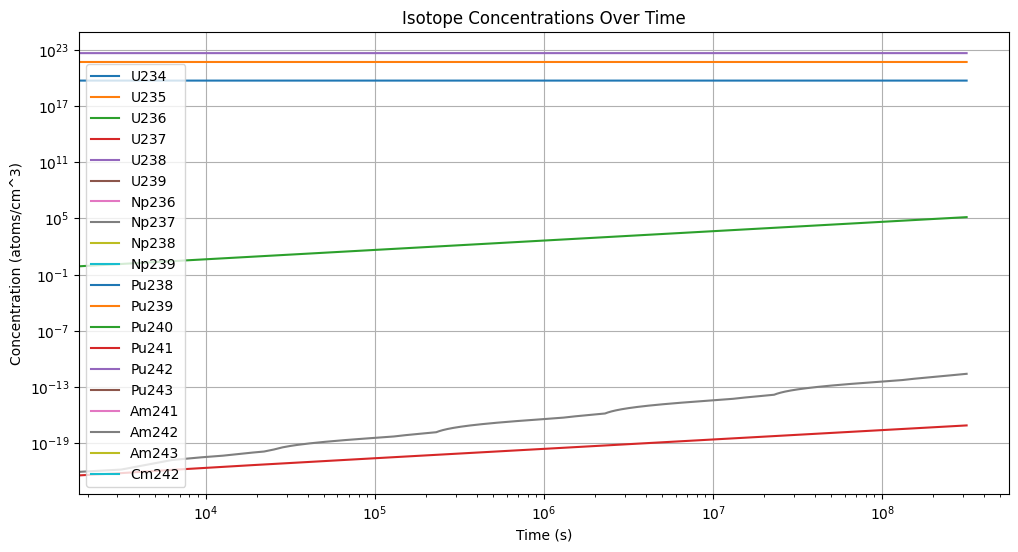


Final concentrations of all 19 isotopes after burnup:
U234: 4.9948e+19
U235: 4.8402e+21
U236: 1.3428e+05
U237: 7.9731e-18
U238: 4.2680e+22
U239: 0.0000e+00
Np236: 0.0000e+00
Np237: 2.5597e-12
Np238: 0.0000e+00
Np239: 0.0000e+00
Pu238: 0.0000e+00
Pu239: 0.0000e+00
Pu240: 0.0000e+00
Pu241: 0.0000e+00
Pu242: 0.0000e+00
Pu243: 0.0000e+00
Am241: 0.0000e+00
Am242: 0.0000e+00
Am243: 0.0000e+00
Cm242: 0.0000e+00


In [55]:
# Define the burnup model parameters
years = float(input("Enter burnup duration in years (e.g., 10): "))
T_end = years * 365.25 * 24 * 3600  # convert
# years to seconds
# Time evaluation points
t_eval = np.linspace(0, T_end, 100000)

#call the ODE solver
sol = solve_ivp(odes, [0, T_end], N0, t_eval=t_eval, method='BDF')
# Ensure all concentrations are non-negative
sol.y = np.abs(sol.y)
# Output the final concentrations
print(f"Final concentrations after {years} years and generated isotopes:")
for i, iso in enumerate(isotope_list):
    val = sol.y[i][-1]
    if val != 0.0:
        print(f"{iso}: {val:.4e}")
#plot
plt.figure(figsize=(12, 6))
for i, iso in enumerate(isotope_list):
    plt.plot(sol.t, sol.y[i], label=iso)
plt.xlabel('Time (s)')
plt.ylabel('Concentration (atoms/cm^3)')
plt.title('Isotope Concentrations Over Time')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

        
        
print("\nFinal concentrations of all 19 isotopes after burnup:")
for i, iso in enumerate(isotope_list):
    val = sol.y[i][-1]
    print(f"{iso}: {val:.4e}")
    

    